# Movie's Recommendation System

In [5]:
## Importing important libraries we will use in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [6]:
## read data sets from data-sets folder

movies = pd.read_csv("data-sets/movies.csv")           ## read the movies list
ratings = pd.read_csv("data-sets/ratings.csv")         ## read the ratings of the users

In [7]:
print(len(movies), len(ratings))                      ## check the number of rows is correct

9742 100836


In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
## reorganize the columns, so every user's ratings will appear in front of his ID
org_set = ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating')

In [11]:
org_set.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
len(org_set)  ## 9724 movie

9724

In [13]:
org_set.fillna(0, inplace=True)    ## replace all "NaN-s" with 0s

In [14]:
org_set.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
## the number of votes for each movie
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')

In [16]:
no_user_voted

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64

In [17]:
## the number of movies each user has voted for
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

In [18]:
no_movies_voted

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64

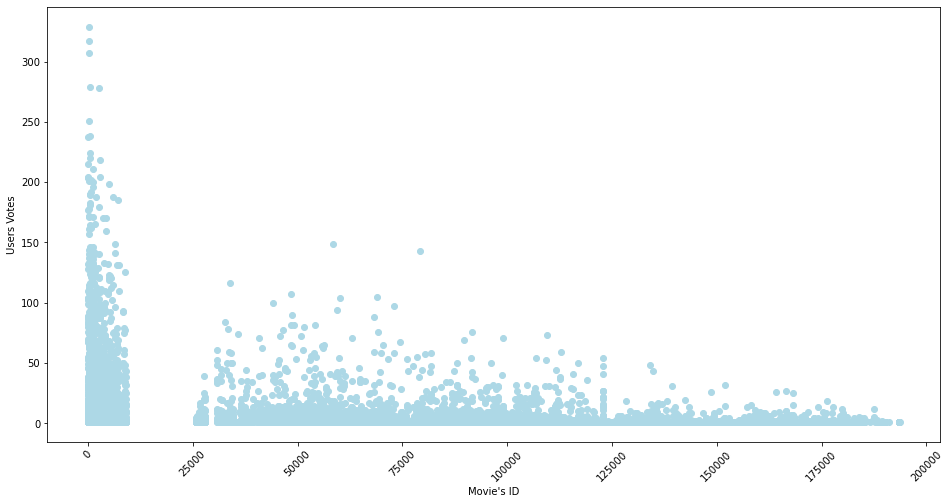

In [19]:
## visualizing the number of votes for each movies
plt.subplots(1,1,figsize=(16,8))
plt.scatter(no_user_voted.index, no_user_voted, color = 'lightblue')

plt.xlabel("Movie's ID")
plt.ylabel("Users Votes")
plt.xticks(rotation = 45)
plt.show()

In [20]:
## Filter the organized data set to just have only users who have voted for more than 50 movies
org_set = org_set.loc[:, no_movies_voted[no_movies_voted>50].index]
org_set

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
csr_set = csr_matrix(org_set.values)   ## convert the org_set to csr file to do operations on it
org_set.reset_index(inplace=True)      ## reset the index of movieID to the org set

In [22]:
org_set

userId,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,193587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
## Starting to use Machine learning
## Using KNN Algorithm to get the closest possible movie for your liking

## using brute forcing algorithm of knn, n_jobs -> using all of the processors, n_neighbors -> number of queiries
knn = NearestNeighbors(metric='cosine', algorithm = 'brute', n_jobs = -1, n_neighbors=20)
knn.fit(csr_set)          ## apply the algorithm on the movies' set

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [24]:
## This is function to re-order data frame
def reset_idx(df):
    res = df.iloc[::-1].reset_index(drop = True)
    res.index +=1
    return res

In [25]:
## the function to get the top 5 recommendations!
def get_recommendation(movie_name, no_recommended_movies = 5):
    
    """"
        this func is to get the top recommendations based on your requested movie
        5 recommended movies is the default, though you can modify it based on your preference
    """
    
#     movie_list = movies[movies['title'].str.contains('movie')]
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):
        movie_idx = movie_list.iloc[0]['movieId']       ## get the index of the movie
        movie_idx = org_set[org_set['movieId'] == movie_idx].index[0]
        dist, idx = knn.kneighbors(csr_set[movie_idx], n_neighbors=no_recommended_movies + 1) ## grab data from csr_set
        
        ## get the indecies of the recommended movies and the distance
        recommended_movies = sorted(list(zip(idx.squeeze().tolist(),dist.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        
        recommended_list =[]
        
        for mov in recommended_movies:
            movie_idx = org_set.iloc[mov[0]]['movieId']
            indx = movies[movies['movieId'] == movie_idx].index
            
            recommended_list.append({'Title': movies.iloc[indx]['title'].values[0], 'Distance': mov[1]})
        
        data_frame = pd.DataFrame(recommended_list, index=range(1, no_recommended_movies+1))
        
        return reset_idx(data_frame)
    else:
        return "[!] Please make sure you entered the right movie!"

In [26]:
get_recommendation("Just Go with It", 10)

,Title,Distance
1,"Change-Up, The (2011)",0.269374
2,Grown Ups 2 (2013),0.291725
3,"Other Woman, The (2014)",0.294499
4,Miss March (2009),0.336889
5,The Boss (2016),0.337620
6,Alice Through the Looking Glass (2016),0.340264
7,"Switch, The (2010)",0.340779
8,Identity Thief (2013),0.356280
9,Neighbors (2014),0.361157
10,"Sitter, The (2011)",0.362504


In [27]:
get_recommendation("Jurassic Park", 10)

,Title,Distance
1,Terminator 2: Judgment Day (1991),0.244425
2,Independence Day (a.k.a. ID4) (1996),0.273255
3,Forrest Gump (1994),0.279047
4,Braveheart (1995),0.299887
5,Speed (1994),0.311626
6,"Fugitive, The (1993)",0.320827
7,Mission: Impossible (1996),0.328245
8,Batman (1989),0.329667
9,Aladdin (1992),0.333249
10,Toy Story (1995),0.334884


-------------------------------------------

## Testing

In [29]:
usr_input = input("[+] Please enter the name of the Movie > ")
rec_num = int(input("[+] Please enter the number of recommendations seeked: "))

if rec_num <1:
    rec_num = 5

get_recommendation(usr_input, rec_num)

'[!] Please make sure you entered the right movie!'

--------------